In [16]:
import scanpy
import anndata
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from scvi.data import smfish, cortex
from scvi.external import GIMVI

train_size = 0.8

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [17]:
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/'

spatial_data = smfish(save_path=f)
seq_data = cortex(save_path=f)

INFO     File /bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/osmFISH_SScortex_
         mouse_all_cell.loom already downloaded                                              
INFO     Loading smFISH dataset                                                              
INFO     File /bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/expression.bin   
         already downloaded                                                                  
INFO     Loading Cortex data from                                                            
         /bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/expression.bin        


/home/fangming/anaconda3/envs/torchgpu/lib/python3.9/site-packages/scvi/data/_built_in_data/_smfish.py:102: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(
/home/fangming/anaconda3/envs/torchgpu/lib/python3.9/site-packages/scvi/data/_built_in_data/_cortex.py:53: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(X=data_df)


INFO     Finished loading Cortex data                                                        


/home/fangming/anaconda3/envs/torchgpu/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
#only use genes in both datasets
seq_data = seq_data[:, spatial_data.var_names].copy()

seq_gene_names = seq_data.var_names
n_genes = seq_data.n_vars
n_train_genes = int(n_genes*train_size)

#randomly select training_genes
rand_train_gene_idx = np.random.choice(range(n_genes), n_train_genes, replace = False)
rand_test_gene_idx = sorted(set(range(n_genes)) - set(rand_train_gene_idx))
rand_train_genes = seq_gene_names[rand_train_gene_idx]
rand_test_genes = seq_gene_names[rand_test_gene_idx]

#spatial_data_partial has a subset of the genes to train on
spatial_data_partial = spatial_data[:,rand_train_genes].copy()

#remove cells with no counts
scanpy.pp.filter_cells(spatial_data_partial, min_counts= 1)
scanpy.pp.filter_cells(seq_data, min_counts = 1)

#setup_anndata for spatial and sequencing data
GIMVI.setup_anndata(spatial_data_partial, labels_key='labels', batch_key='batch')
GIMVI.setup_anndata(seq_data, labels_key='labels')

#spatial_data should use the same cells as our training data
#cells may have been removed by scanpy.pp.filter_cells()
spatial_data = spatial_data[spatial_data_partial.obs_names]

In [20]:
#create our model
model = GIMVI(seq_data, spatial_data_partial)

#train for 200 epochs
model.train(200)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/home/fangming/anaconda3/envs/torchgpu/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/fangming/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)
/home/fangming/anaconda3/envs/torchgpu/lib/python3.9/site-packages/pytorch_lightning/loops/optimization/closure.py:35: LightningDeprecationWarning: One of the returned values {'kl_local_sum', 'n_obs', 'kl_global', 'reconstruction_loss_sum'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


Epoch 200/200: 100%|██████████| 200/200 [04:02<00:00,  1.21s/it, loss=25.2, v_num=1]


In [21]:
#get the latent representations for the sequencing and spatial data
latent_seq, latent_spatial = model.get_latent_representation()

#concatenate to one latent representation
latent_representation = np.concatenate([latent_seq, latent_spatial])
latent_adata = anndata.AnnData(latent_representation)

#labels which cells were from the sequencing dataset and which were from the spatial dataset
latent_labels = (['seq'] * latent_seq.shape[0]) + (['spatial'] * latent_spatial.shape[0])
latent_adata.obs['labels'] = latent_labels

#compute umap
scanpy.pp.neighbors(latent_adata, use_rep = 'X')
scanpy.tl.umap(latent_adata)

#save umap representations to original seq and spatial_datasets
seq_data.obsm['X_umap'] = latent_adata.obsm['X_umap'][:seq_data.shape[0]]
spatial_data.obsm['X_umap'] = latent_adata.obsm['X_umap'][seq_data.shape[0]:]

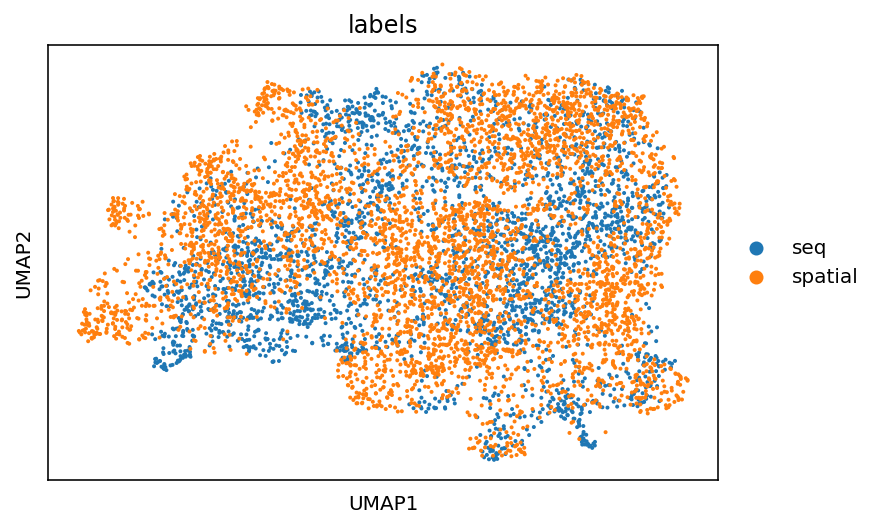

In [23]:
#umap of the combined latent space
scanpy.pl.umap(latent_adata, color = 'labels', show = True)

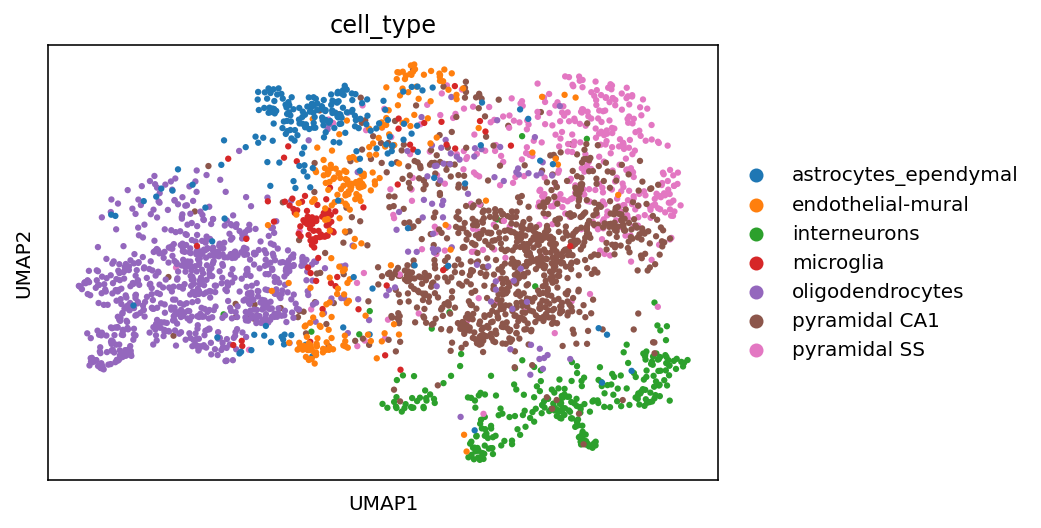

In [24]:
#umap of sequencing dataset
scanpy.pl.umap(seq_data, color = 'cell_type')

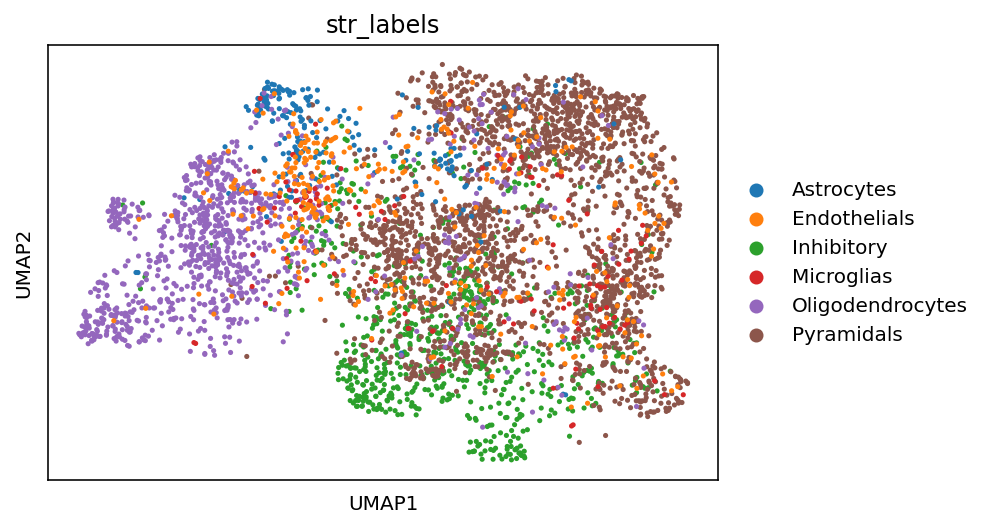

In [25]:
#umap of spatial dataset
scanpy.pl.umap(spatial_data, color = 'str_labels')

In [26]:
# utility function for scoring the imputation
def imputation_score(model, data_spatial, gene_ids_test, normalized=True):
    _, fish_imputation = model.get_imputed_values(normalized=normalized)
    original, imputed = (
        data_spatial.X[:, gene_ids_test],
        fish_imputation[:, gene_ids_test],
    )

    if normalized:
        original /= data_spatial.X.sum(axis=1).reshape(-1, 1)

    spearman_gene = []
    for g in range(imputed.shape[1]):
        if np.all(imputed[:, g] == 0):
            correlation = 0
        else:
            correlation = spearmanr(original[:, g], imputed[:, g])[0]
        spearman_gene.append(correlation)
    return np.median(np.array(spearman_gene))

imputation_score(model, spatial_data, rand_test_gene_idx, True)

0.12289395301608075

In [27]:
#utility function for plotting spatial genes
def plot_gene_spatial(model, data_spatial, gene):
    data_seq = model.adatas[0]
    data_fish = data_spatial

    fig, (ax_gt, ax) = plt.subplots(1, 2)

    if type(gene) == str:
        gene_id = list(data_seq.gene_names).index(gene)
    else:
        gene_id = gene

    x_coord = data_fish.obs["x_coord"]
    y_coord = data_fish.obs["y_coord"]

    def order_by_strenght(x, y, z):
        ind = np.argsort(z)
        return x[ind], y[ind], z[ind]

    s = 20

    def transform(data):
        return np.log(1 + 100 * data)

    # Plot groundtruth
    x, y, z = order_by_strenght(
        x_coord, y_coord, data_fish.X[:, gene_id] / (data_fish.X.sum(axis=1) + 1)
    )
    ax_gt.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax_gt.set_title("Groundtruth")
    ax_gt.axis("off")

    _, imputed = model.get_imputed_values(normalized=True)
    x, y, z = order_by_strenght(x_coord, y_coord, imputed[:, gene_id])
    ax.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax.set_title("Imputed")
    ax.axis("off")
    plt.tight_layout()
    plt.show()

assert 'Lamp5' in rand_test_genes
plot_gene_spatial(model, spatial_data, 9)

AssertionError: 